In [75]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Predict model performance

In [76]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [77]:
DATA_PATH = 'data/aggregated/experiments.csv'

Data

In [78]:
df = pd.read_csv(DATA_PATH)
df.head(5)

,topology,cells_number,possible_moves,connection_degree,depth,mean_log2_max_tile
0,hex,19,6,4.421053,2,11.275
1,hex,19,6,4.421053,1,11.105
2,hex,19,6,4.421053,4,13.065
3,hex,19,6,4.421053,3,13.130
4,hex,19,6,4.421053,0,9.120


Model training

In [79]:
features = ['cells_number', 'possible_moves', 'connection_degree', 'depth']
X = df[features].values
y = df['mean_log2_max_tile'].values

In [80]:
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

Evaluating

In [81]:
X_pred = sm.add_constant(X)
y_pred = model.predict(X_pred)

In [82]:
df['predicted_mean_log2_max_tile'] = y_pred
df_comparison = df[['depth', 'cells_number', 'possible_moves', 'connection_degree', 'mean_log2_max_tile', 'predicted_mean_log2_max_tile']]

Understanding the model

In [83]:
summary_df = pd.DataFrame({
    "feature": ["intercept", "cells_number", "possible_moves", "connection_degree", "depth"],
    "coef": model.params,
    "std_error": model.bse,
    "p_value": model.pvalues
}).sort_values(by="coef", ascending=False)
summary_df

,feature,coef,std_error,p_value
4,depth,0.697400,0.084254,6.857939e-08
2,possible_moves,0.641095,0.266127,2.575684e-02
1,cells_number,0.411684,0.027122,1.933925e-12
3,connection_degree,0.194200,0.409605,6.405531e-01
0,intercept,-2.545328,0.780274,3.901101e-03


Comparing predicted performance across different depths











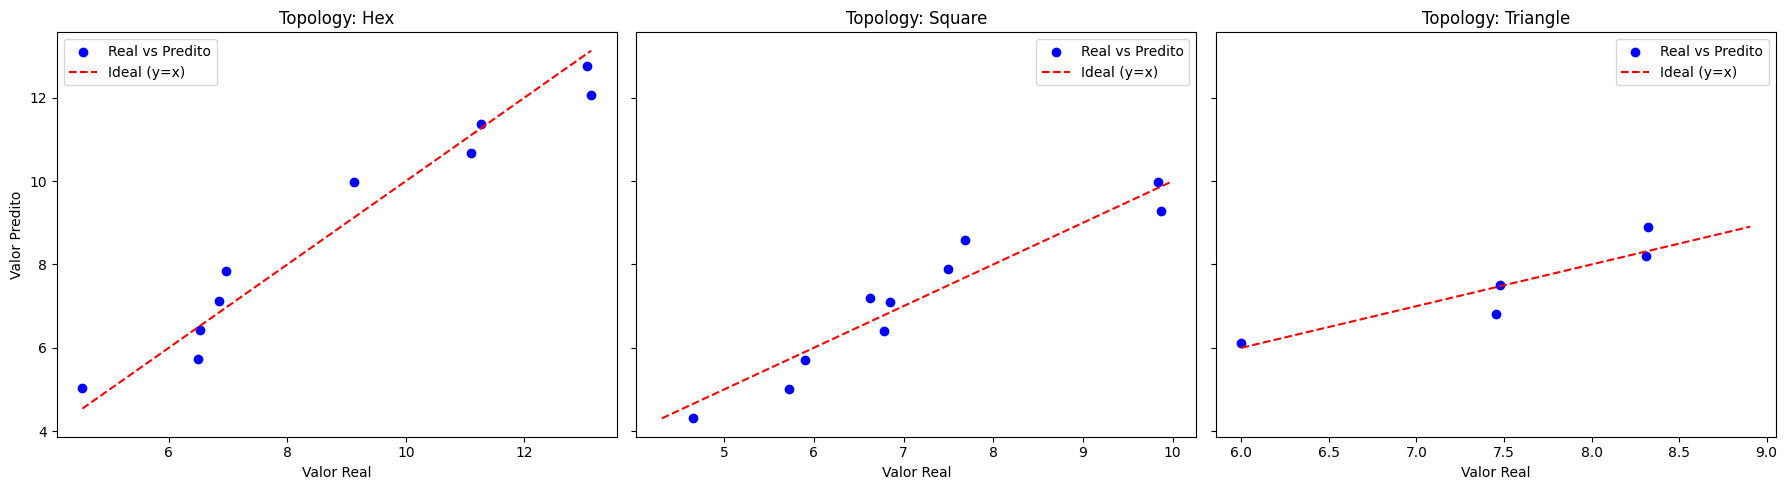

In [84]:
topologies = df["topology"].unique()
n_topos = len(topologies)

fig, axes = plt.subplots(nrows=1, ncols=n_topos, figsize=(6 * n_topos, 5), sharey=True)

if n_topos == 1:
    axes = [axes]

for ax, topo in zip(axes, topologies):
    topo_df = df[df["topology"] == topo]

    ax.scatter(
        topo_df["mean_log2_max_tile"],
        topo_df["predicted_mean_log2_max_tile"],
        color='blue',
        marker='o',
        label='Real vs Predito'
    )
    
    # Linha y = x (linha de referência ideal)
    min_val = min(topo_df["mean_log2_max_tile"].min(), topo_df["predicted_mean_log2_max_tile"].min())
    max_val = max(topo_df["mean_log2_max_tile"].max(), topo_df["predicted_mean_log2_max_tile"].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y=x)')

    ax.set_title(f"Topology: {topo.capitalize()}")
    ax.set_xlabel("Valor Real")
    ax.legend()

axes[0].set_ylabel("Valor Predito")

plt.tight_layout()
plt.show()

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Supondo que X seja o dataframe só com suas features numéricas (sem a variável target)
X = df.drop(columns=['mean_log2_max_tile', 'predicted_mean_log2_max_tile', 'topology'])  # Ajuste conforme suas colunas

# Se tiver variáveis categóricas transformadas em dummies, pode manter no X

# Adiciona uma constante (bias) para o cálculo de VIF
from statsmodels.tools.tools import add_constant
X_const = add_constant(X)

# Calcula VIF para cada variável
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

             feature        VIF
0              const  42.882496
1       cells_number   1.065285
2     possible_moves   4.788885
3  connection_degree   4.795820
4              depth   1.000000


In [86]:
df[['possible_moves', 'connection_degree']].corr()

,possible_moves,connection_degree
possible_moves,1.000000,0.882338
connection_degree,0.882338,1.000000
